In [1]:
# As copied from:
# /home/scratch/lmorgan/Projects/GalacticBar/Midpoint_PaperII/Scripts/RAMPS_NH3_Fitting.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings
from astropy.wcs import WCS
from astropy.io import fits
from scipy.optimize import curve_fit, root_scalar
from spectral_cube import SpectralCube
from lmfit import Model, Parameters
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

In [3]:
def gaussian(x, amp, vel, sigma):
    return amp * np.exp(-(x - vel)**2 / (2 * sigma**2))

def gaussian2c(x, amp0, vel0, sigma0, amp1, vel1, sigma1):
    return (amp0 * np.exp(-(x - vel0)**2 / (2 * sigma0**2))) + (amp1 * np.exp(-(x - vel1)**2 / (2 * sigma1**2)))

def quad_func(x, amp0, vel0, sigma0, tau0):
    amp = [0.226, 0.273, 1.0, 0.277, 0.219]
    vel = [-19.503, -7.594, 0.0, 7.599, 19.493]
    emission_profile = np.zeros_like(x)
    for ampi, veli in zip(amp, vel):
        Tq=(1-np.exp(-ampi*tau0))/(1-np.exp(-tau0))
        emission_profile += gaussian(x, Tq, vel0 + veli, sigma0)
    return amp0*emission_profile

def quad_func2c(x, amp0, vel0, sigma0, tau0, amp1, vel1, sigma1, tau1):
    amp = [0.226, 0.273, 1.0, 0.277, 0.219]
    vel = [-19.503, -7.594, 0.0, 7.599, 19.493]

    emission_profile0 = np.zeros_like(x)
    emission_profile1 = np.zeros_like(x)
    for ampi, veli in zip(amp, vel):
        Tq0=(1-np.exp(-ampi*tau0))/(1-np.exp(-tau0))
        Tq1=(1-np.exp(-ampi*tau1))/(1-np.exp(-tau1))
        emission_profile0 += gaussian(x, Tq0, vel0 + veli, sigma0)
        emission_profile1 += gaussian(x, Tq1, vel1 + veli, sigma1)
    return amp0*emission_profile0+amp1*emission_profile1

def select_best_model_with_sanity_checks(model_results, w_bic=0.5, w_chi2=0.5, penalty_weight=5.0, min_delta_bic=6.0):
    """
    Select the best model considering BIC, reduced chi-squared, and penalizing poorly constrained fits.
    Requires that the best model's BIC is at least min_delta_bic lower than the second-best.

    Parameters:
        model_results (list): List of lmfit ModelResult objects.
        w_bic (float): Weight for BIC in scoring.
        w_chi2 (float): Weight for reduced chi-squared in scoring.
        penalty_weight (float): How strongly to penalize models with parameters at limits or large errors.
        min_delta_bic (float): Minimum BIC difference required to accept a best model.

    Returns:
        ModelResult or None: Best model if significantly better; otherwise None.
    """
    if len(model_results) < 2:
        return model_results[0] if model_results else None

    model_complexities = np.array([len(res.var_names) for res in model_results])
    complexity_weight = 0.2  # Adjust as needed
    bics = np.array([res.bic for res in model_results])
    redchis = np.array([res.redchi for res in model_results])

    # Normalize with z-score
    def zscore(x):
        return (x - np.mean(x)) / (np.std(x) + 1e-10)

    norm_bics = zscore(bics)
    norm_chis = zscore(redchis)

    penalties = []
    for res in model_results:
        penalty = 0
        for name, par in res.params.items():
            if par.min is not None and np.isclose(par.value, par.min, atol=1e-3):
                penalty += 1
            if par.max is not None and np.isclose(par.value, par.max, atol=1e-3):
                penalty += 1
            if par.stderr is not None and par.value != 0:
                rel_err = abs(par.stderr / par.value)
                if rel_err > 1.0:
                    penalty += 1
        penalties.append(penalty)

    penalties = np.array(penalties)
    total_score = w_bic * norm_bics + w_chi2 * norm_chis + penalty_weight * penalties + complexity_weight * model_complexities

    # print('w_bic - ', norm_bics)
    # print('w_chi2 - ', norm_chis)
    # print('penalties - ', penalties)
    # print('total score - ', total_score)

    best_index = np.argmin(total_score)

    # Check ΔBIC condition
    sorted_bics = np.sort(bics)
    delta_bic = sorted_bics[1] - sorted_bics[0]
    # print('delta_bic - ',delta_bic < min_delta_bic)
    # print(f"best_index = {best_index}, best BIC = {bics[best_index]:.2f}")
    # print(f"All BICs: {bics}")
    # print(f"delta_bic = {delta_bic}, min_delta_bic = {min_delta_bic}")
    # print("Comparison result:", delta_bic < min_delta_bic)

    # if delta_bic < min_delta_bic:
    #     print(f"No model exceeds ΔBIC > {min_delta_bic}. Best ΔBIC = {delta_bic:.2f}")
    #     return None

    return model_results[best_index]

In [4]:
# File paths
path = '/home/scratch/hfwest/RAMPS/'
outdir = path+'Results/'
suffixout='10sig'
Cube = SpectralCube.read(path + 'Data/L28_5_NH3_1-1_cube.fits')
prefixout = 'L28_5_NH3_1-1'
print(Cube.shape)

(854, 520, 598)


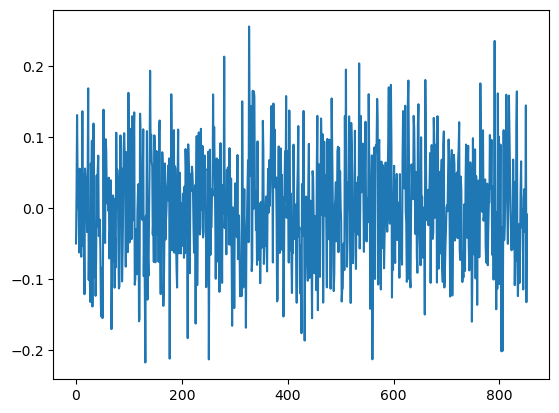

In [ ]:
plt.plot(Cube[:, 320, 396])
plt.show()

In [ ]:
warnings.filterwarnings('ignore')
# Constants
etamb = 0.89
etaf = 1.0
nu11 = 23.6944955e9
nu33 = 23.8701292e9
h = 6.62606896e-34
kB = 1.3806504e-23
Tbg = 2.73
c = 2.99792458e8
To = 41.5
epsilon = 8.854187817e-12
dipole = 298117.06e6
C_moment = 186726.36e6
mu = 1.476 * 3.336e-30
mu11 = mu ** 2 * (1. / 2.)
Einstein_A = (16. * np.pi ** 3 / (3. * epsilon * h * c ** 3)) * nu11 ** 3 * abs(mu11)
etac = etamb * etaf
mNH3=17.03      #amu
mH=1.00794      #amu
amu=1.66053886e-27  #kg

vmargin = 50.
threshold = 1   # N sigma level to fit above: Possibly raise to 3?
min_peak_separation_chan = 3
hf_lv = 0.5
vl = 30 * u.km / u.s       #bounds of observed emission: modify for each cube used
vh = 130 * u.km / u.s
rmsvl = -20 * u.km / u.s    #bounds of emission used for noise estimation: modify for each cube used
rmsvh = 25 * u.km / u.s

In [7]:
# Grab the middle channel as a 2D slice
slice2d = Cube[Cube.spectral_axis.size // 2]

# Get the WCS from the 2D slice
wcs_3d = Cube.wcs
wcs_2d = slice2d.wcs

# Convert to header
header_3d = wcs_3d.to_header()
header_2d = wcs_2d.to_header()
restnu=header_3d['RESTFRQ']
J_Tbg = h * restnu / kB * (1. / (np.exp(h * restnu / (kB * Tbg)) - 1))

# Optionally: copy over some key metadata from the original header
for key in ['BUNIT', 'OBJECT', 'TELESCOP', 'DATE-OBS']:
    if key in Cube.header:
        header_2d[key] = Cube.header[key]

Cube = Cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restnu*u.Hz)
full_vel_axis = Cube.spectral_axis

In [8]:
Cube_slab = Cube.spectral_slab(vl, vh)
RMS_slab = Cube.spectral_slab(rmsvl, rmsvh)
vel_axis = Cube_slab.spectral_axis
cube_data = Cube_slab.unmasked_data[:].value
rms_data = RMS_slab.unmasked_data[:].value

nz, ny, nx = Cube.shape[0], Cube.shape[1], Cube.shape[2]
print(nz, ny, nx)

FitCube = np.zeros((nz, ny, nx))
FitCube1c = np.zeros((nz, ny, nx))
FitCube2c = np.zeros((nz, ny, nx))
NCompMap = np.zeros((ny, nx))
TMax1cMap = np.zeros((ny, nx))
Vel1cMap = np.zeros((ny, nx))
Sigma1cMap = np.zeros((ny, nx))
Tau1cMap = np.zeros((ny, nx))
TMax2c1Map = np.zeros((ny, nx))
Vel2c1Map = np.zeros((ny, nx))
Sigma2c1Map = np.zeros((ny, nx))
Tau2c1Map = np.zeros((ny, nx))
TMax2c2Map = np.zeros((ny, nx))
Vel2c2Map = np.zeros((ny, nx))
Sigma2c2Map = np.zeros((ny, nx))
Tau2c2Map = np.zeros((ny, nx))

model1c = Model(quad_func)
model2c = Model(quad_func2c)

854 520 598


In [ ]:
yyy = range(ny)
xxx = range(nx)

for j in yyy:
    print(f'Row: {j} of {ny}')
    for i in xxx:
        spec = cube_data[:, j, i]
        rms = np.std(rms_data[:, j, i])  # emission-free region of spectrum
        peaks, props = find_peaks(spec, height=threshold * rms, distance=min_peak_separation_chan)
        print(f'Peak count: {len(peaks)}')
        if len(peaks) > 0:
            sorted_idx = np.argsort(props['peak_heights'])[::-1]
            pmax = peaks[sorted_idx[0]]
            amp0 = spec[pmax]
            vel0 = vel_axis[pmax]
            mask = (vel_axis.value > vel0.value - vmargin) & (vel_axis.value < vel0.value + vmargin)
            vel_axis_clip = vel_axis[mask]
            spec_clip = spec[mask]

            if len(peaks) == 1:
                params1c = Parameters()
                params1c.add('amp0', value=float(amp0), min=threshold * rms)
                params1c.add('vel0', value=float(vel0.value))
                params1c.add('sigma0', value=1.0, min=0.01)
                params1c.add('tau0', value=1.0, min=0.01)

                result1c = model1c.fit(spec_clip, params1c, x=vel_axis_clip.value)
                TMax1c = result1c.params['amp0'].value
                Vel1c = result1c.params['vel0'].value
                Sigma1c = result1c.params['sigma0'].value
                Tau1c = result1c.params['tau0'].value
                y1c = quad_func(full_vel_axis.value, TMax1c, Vel1c, Sigma1c, Tau1c)

                TMax1cMap[j,i] = TMax1c
                Vel1cMap[j,i] = Vel1c
                Sigma1cMap[j,i] = Sigma1c
                Tau1cMap[j,i] = Tau1c
                NCompMap[j,i] = 1

                FitCube[:,j,i] = gaussian(full_vel_axis.value, TMax1c, Vel1c, Sigma1c)
                FitCube1c[:,j,i] = gaussian(full_vel_axis.value, TMax1c, Vel1c, Sigma1c)
            if len(peaks) > 1:
                p2 = peaks[sorted_idx[1]]
                amp1 = spec[p2]
                vel1 = vel_axis[p2]

                params1c = Parameters()
                params1c.add('amp0', value=float(amp0), min=threshold * rms)
                params1c.add('vel0', value=float(vel0.value))
                params1c.add('sigma0', value=1.0, min=0.01, max=25)
                params1c.add('tau0', value=1.0, min=0.01)

                result1c = model1c.fit(spec_clip, params1c, x=vel_axis_clip.value)
                TMax1c = result1c.params['amp0'].value
                Vel1c = result1c.params['vel0'].value
                Sigma1c = result1c.params['sigma0'].value
                Tau1c = result1c.params['tau0'].value
                y1c = quad_func(full_vel_axis.value, TMax1c, Vel1c, Sigma1c, Tau1c)

                params2c = Parameters()
                params2c.add('amp0', value=float(amp0), min=threshold * rms, max=float(amp0)*1.2)
                params2c.add('vel0', value=float(vel0.value))
                params2c.add('sigma0', value=1.0, min=0.01, max=25)
                params2c.add('tau0', value=1.0, min=0.01)
                params2c.add('amp1', value=float(amp1), min=hf_lv * amp0, max=float(amp0))
                params2c.add('vel1', value=float(vel1.value), min=np.nanmin(vel_axis_clip.value), max=np.nanmax(vel_axis_clip.value))
                params2c.add('sigma1', value=1.0, min=0.01, max=25)
                params2c.add('tau1', value=1.0, min=0.01)

                result2c = model2c.fit(spec_clip, params2c, x=vel_axis_clip.value)
                TMax2c1 = result2c.params['amp0'].value
                Vel2c1 = result2c.params['vel0'].value
                Sigma2c1 = result2c.params['sigma0'].value
                Tau2c1 = result2c.params['tau0'].value
                TMax2c2 = result2c.params['amp1'].value
                Vel2c2 = result2c.params['vel1'].value
                Sigma2c2 = result2c.params['sigma1'].value
                Tau2c2 = result2c.params['tau1'].value
                y2c = quad_func2c(full_vel_axis.value, TMax2c1, Vel2c1, Sigma2c1, Tau2c1, TMax2c2, Vel2c2, Sigma2c2, Tau2c2)

                best_result = select_best_model_with_sanity_checks([result1c, result2c])
                ncomp = [result1c, result2c].index(best_result) + 1
                if ncomp == 1:
                    FitCube[:,j,i] = gaussian(full_vel_axis.value, TMax1c, Vel1c, Sigma1c)
                    FitCube1c[:,j,i] = gaussian(full_vel_axis.value, TMax1c, Vel1c, Sigma1c)
                    TMax1cMap[j,i] = TMax1c
                    Vel1cMap[j,i] = Vel1c
                    Sigma1cMap[j,i] = Sigma1c
                    Tau1cMap[j,i] = Tau1c
                elif ncomp == 2:
                    FitCube[:,j,i] = gaussian2c(full_vel_axis.value, TMax2c1, Vel2c1, Sigma2c1, TMax2c2, Vel2c2, Sigma2c2)
                    if TMax2c1 > TMax2c2:
                        FitCube1c[:,j,i] = gaussian(full_vel_axis.value, TMax2c1, Vel2c1, Sigma2c1)
                        FitCube2c[:,j,i] = gaussian(full_vel_axis.value, TMax2c2, Vel2c2, Sigma2c2)
                    else:
                        FitCube1c[:,j,i] = gaussian(full_vel_axis.value, TMax2c2, Vel2c2, Sigma2c2)
                        FitCube2c[:,j,i] = gaussian(full_vel_axis.value, TMax2c1, Vel2c1, Sigma2c1)
                    TMax2c1Map[j,i] = TMax2c1
                    Vel2c1Map[j,i] = Vel2c1
                    Sigma2c1Map[j,i] = Sigma2c1
                    Tau2c1Map[j,i] = Tau2c1
                    TMax2c2Map[j,i] = TMax2c2
                    Vel2c2Map[j,i] = Vel2c2
                    Sigma2c2Map[j,i] = Sigma2c2
                    Tau2c2Map[j,i] = Tau2c2
                NCompMap[j,i] = ncomp

52
59
52
44
50
54
49
54
48
50
47
58
52
64
55
50
55
62
47
57
63
61
62
58
59
55
55
50
52
43
57
51
55
61
55
64
52
61
55
68
66
54
52
59
59
49
53
66
58
55
53
54
54
53
64
58
56
61
56
54
52
55
64
59
62
58
55
54
63
67
63
55
53
66
62
48
49
49
51
51
57
43
53
55
54
52
49
51
55
56
53
56
61
57
53
63
60
58
54
60
56
61
61
63
56
52
46
52
60
57
69
67
58
53
46
61
64
55
57
49
54
71
55
49
57
50
54
48
51
43
53
51
54
55
52
58
62
54
45
51
54
52
57
52
55
55
48
57
57
54
56
62
49
54
52
50
52
53
54
50
50
47
57
61
55
48
47
50
51
46
51
63
49
43
55
53
55
50
52
55
53
70
53
46
45
50
48
49
56
56
49
53
54
50
57
44
50
63
55
59
55
52
51
50
42
49
53
52
45
49
58
48
49
47
60
46
63
65
57
51
55
57
58
51
50
60
48
53
52
57
54
56
56
52
56
59
58
45
53
53
60
57
54
49
55
51
52
48
44
47
57
63
67
57
56
59
55
56
48
49
53
51
52
39
55
58
57
57
54
54
54
65
38
57
57
66
57
66
58
59
59
47
49
61
61
59
50
50
49
53
49
50
53
46
45
59
54
50
51
54
54
50
47
53
59
58
43
47
50
52
56
60
61
52
62
53
52
50
50
49
45
41
51
51
50
57
51
51
56
49
47
52
52
4

In [ ]:
Fithdu = fits.PrimaryHDU(FitCube, header=header_3d)
Fithdu.writeto(outdir+prefixout+'_Fit'+suffixout+'.fits', overwrite=True)
Fit1chdu = fits.PrimaryHDU(FitCube1c, header=header_3d)
Fit1chdu.writeto(outdir+prefixout+'_Fit1stcomp'+suffixout+'.fits', overwrite=True)
Fit2chdu = fits.PrimaryHDU(FitCube2c, header=header_3d)
Fit2chdu.writeto(outdir+prefixout+'_Fit2ndcomp'+suffixout+'.fits', overwrite=True)
NComphdu = fits.PrimaryHDU(NCompMap, header=header_2d)
NComphdu.writeto(outdir+prefixout+'_NComp_Fit'+suffixout+'.fits', overwrite=True)
TMax1chdu = fits.PrimaryHDU(TMax1cMap, header=header_2d)
TMax1chdu.writeto(outdir+prefixout+'_TMax1c_Fit'+suffixout+'.fits', overwrite=True)
Vel1chdu = fits.PrimaryHDU(Vel1cMap, header=header_2d)
Vel1chdu.writeto(outdir+prefixout+'_Vel1c_Fit'+suffixout+'.fits', overwrite=True)
Sigma1chdu = fits.PrimaryHDU(Sigma1cMap, header=header_2d)
Sigma1chdu.writeto(outdir+prefixout+'_Sigma1c_Fit'+suffixout+'.fits', overwrite=True)
Tau1chdu = fits.PrimaryHDU(Tau1cMap, header=header_2d)
Tau1chdu.writeto(outdir+prefixout+'_Tau1c_Fit'+suffixout+'.fits', overwrite=True)
TMax2c1hdu = fits.PrimaryHDU(TMax2c1Map, header=header_2d)
TMax2c1hdu.writeto(outdir+prefixout+'_TMax2c1_Fit'+suffixout+'.fits', overwrite=True)
Vel2c1hdu = fits.PrimaryHDU(Vel2c1Map, header=header_2d)
Vel2c1hdu.writeto(outdir+prefixout+'_Vel2c1_Fit'+suffixout+'.fits', overwrite=True)
Sigma2c1hdu = fits.PrimaryHDU(Sigma2c1Map, header=header_2d)
Sigma2c1hdu.writeto(outdir+prefixout+'_Sigma2c1_Fit'+suffixout+'.fits', overwrite=True)
Tau2c1hdu = fits.PrimaryHDU(Tau2c1Map, header=header_2d)
Tau2c1hdu.writeto(outdir+prefixout+'_Tau2c1_Fit'+suffixout+'.fits', overwrite=True)
TMax2c2hdu = fits.PrimaryHDU(TMax2c2Map, header=header_2d)
TMax2c2hdu.writeto(outdir+prefixout+'_TMax2c2_Fit'+suffixout+'.fits', overwrite=True)
Vel2c2hdu = fits.PrimaryHDU(Vel2c2Map, header=header_2d)
Vel2c2hdu.writeto(outdir+prefixout+'_Vel2c2_Fit'+suffixout+'.fits', overwrite=True)
Sigma2c2hdu = fits.PrimaryHDU(Sigma2c2Map, header=header_2d)
Sigma2c2hdu.writeto(outdir+prefixout+'_Sigma2c2_Fit'+suffixout+'.fits', overwrite=True)
Tau2c2hdu = fits.PrimaryHDU(Tau2c2Map, header=header_2d)
Tau2c2hdu.writeto(outdir+prefixout+'_Tau2c2_Fit'+suffixout+'.fits', overwrite=True)